# Classifying outcomes with logistic regression

This is the code is adapted from [Bayesian Analysis with Python](https://github.com/aloctavodia/BAP).


In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

import warnings
warnings.filterwarnings("ignore")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/ohalloranb/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Text(0,0.5,'$logistic(z)$')

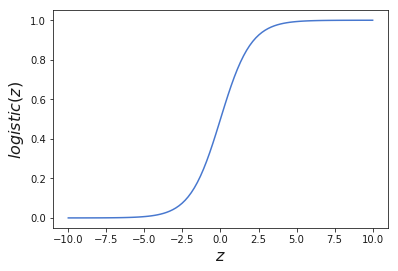

In [2]:
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))
plt.plot(z, logistic)
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$logistic(z)$', fontsize=16)


In [3]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


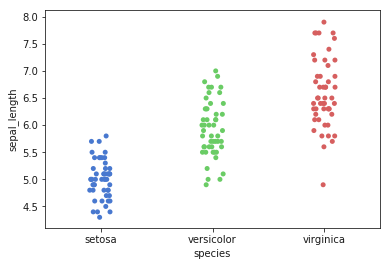

In [4]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)


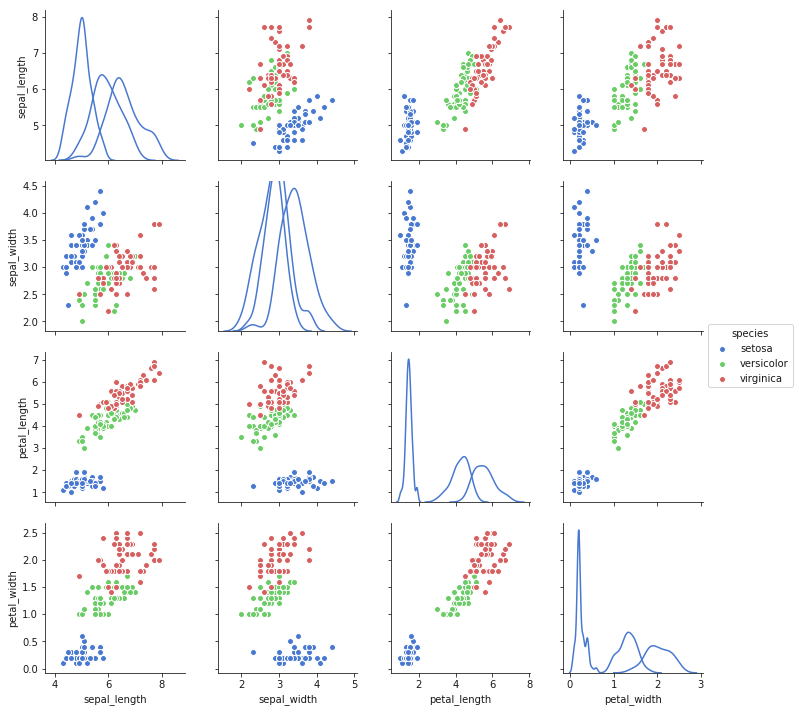

In [5]:
sns.pairplot(iris, hue='species', diag_kind='kde')


In [6]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [7]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_0, beta)
    #theta = pm.Deterministic('theta', tt.nnet.sigmoid(mu))
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(5000, step, start)

logp = -41.726, ||grad|| = 3.5299e-05: 100%|██████████| 23/23 [00:00<00:00, 2608.40it/s]  
100%|██████████| 5500/5500 [00:13<00:00, 420.61it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2dc228908>,
      dtype=object)

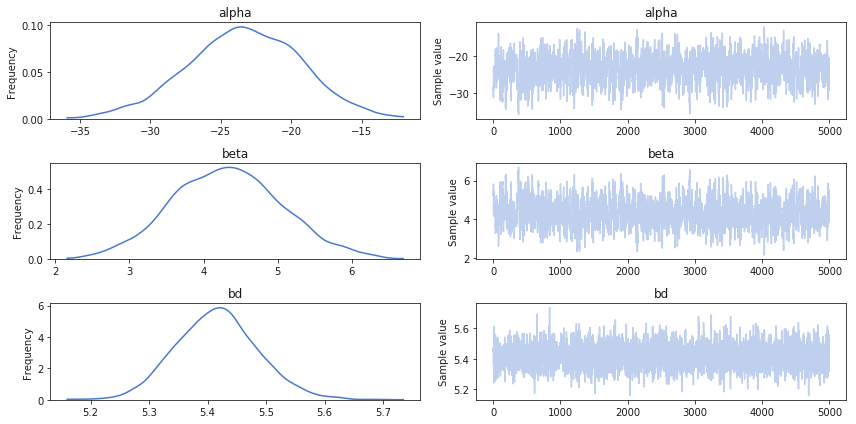

In [8]:
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(trace_0, varnames)


In [9]:
#pm.autocorrplot(trace_0, varnames);

In [10]:
#sns.kdeplot(trace_0['alpha'], cadena_0['beta']);

In [11]:
pm.df_summary(trace_0, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-23.41,3.99,1.45e-01,-32.06,-16.19
beta,4.32,0.74,2.68e-02,2.79,5.73
bd,5.41,0.07,1.03e-03,5.28,5.55


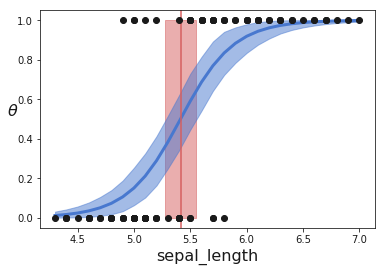

In [12]:
theta = trace_0['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_0['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(trace_0['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)
plt.savefig('B04958_05_06.png', dpi=300, figsize=(5.5, 5.5))

In [13]:
def classify(n, threshold):
    """
    A simple classifying function
    """
    n = np.array(n)
    mu = trace_0['alpha'].mean() + trace_0['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob >= threshold

classify([5, 5.5, 6], 0.5)

(array([0.14, 0.59, 0.93]), array([False,  True,  True]))

## Multiple logistic regression

In [14]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] #['petal_length', 'petal_width'] 
x_1 = df[x_n].values

#x_1 = (x_1 - x_1.mean(axis=0))/x_1.std(axis=0) #
#x_1 = (x_1 - x_1.mean(axis=0))

In [15]:
with pm.Model() as model_1:
    # We define the prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_1, beta)
    # Aplly the logistic linking function
    theta = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_1[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)
    # Sampling
    #start = pm.find_MAP()
    #step = pm.NUTS()
    #trace_1 = pm.sample(5000, step, start)
    trace_1 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:22<00:00, 245.18it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2e07664a8>,
      dtype=object)

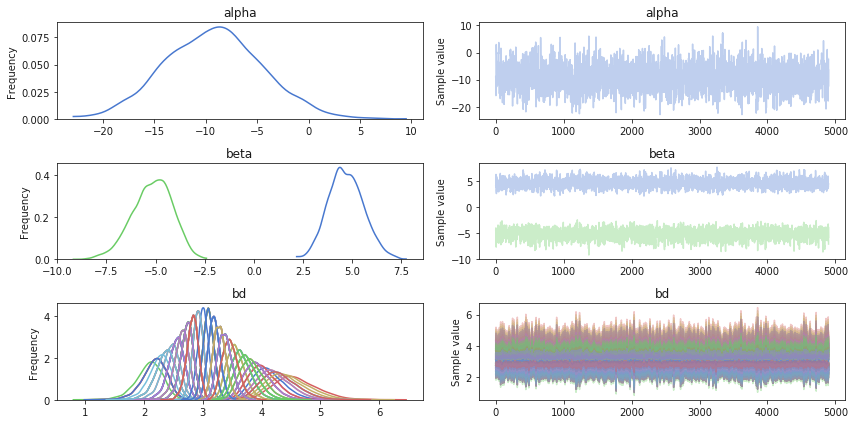

In [16]:
chain_1 = trace_1[100:]
pm.traceplot(chain_1)


In [17]:
#pm.df_summary(chain_1, ['alpha', 'beta'])

Text(0,0.5,'sepal_width')

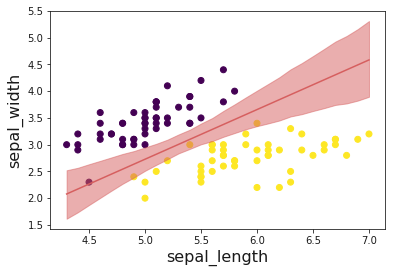

In [18]:
idx = np.argsort(x_1[:,0])
ld = chain_1['bd'].mean(0)[idx]
plt.scatter(x_1[:,0], x_1[:,1], c=y_0)
plt.plot(x_1[:,0][idx], ld, color='r');

ld_hpd = pm.hpd(chain_1['bd'])[idx]
plt.fill_between(x_1[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)


## Correlated variables

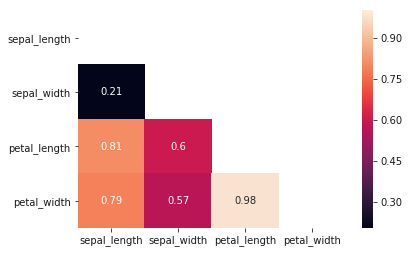

In [19]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True)


## Unbalanced Classes

In [20]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:] #df[22:78]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values
#plt.scatter(x_3[:,0], x_3[:,1], c=y_3)

In [21]:
with pm.Model() as model_3:
    # We define the a prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_3, beta)
    # Aplly the logistic linking function
    p = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    ld = pm.Deterministic('ld', -alpha/beta[1] - beta[0]/beta[1] * x_3[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_3)
    trace_3 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:20<00:00, 263.00it/s]


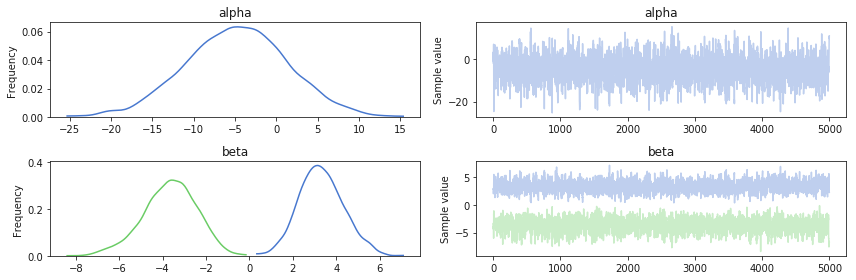

In [22]:
cadena_3 = trace_3[:]
varnames = ['alpha', 'beta']
pm.traceplot(cadena_3, varnames);

In [23]:
pm.df_summary(cadena_3, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-4.80,6.18,0.16,-16.73,7.55
beta__0,3.30,1.02,0.02,1.33,5.35
beta__1,-3.69,1.22,0.03,-6.14,-1.34


Text(0,0.5,'sepal_width')

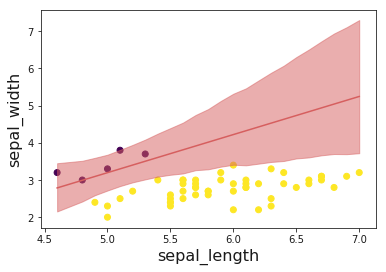

In [24]:
idx = np.argsort(x_3[:,0])
ld = trace_3['ld'].mean(0)[idx]
plt.scatter(x_3[:,0], x_3[:,1], c=y_3)
plt.plot(x_3[:,0][idx], ld, color='r');

ld_hpd = pm.hpd(trace_3['ld'])[idx]
plt.fill_between(x_3[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)


## Softmax logistic regression (AKA multinomial regression)

In [25]:
iris = sns.load_dataset("iris")
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)
#x_s = (x_s - x_s.mean(axis=0))

In [26]:
with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,3))

    mu = alpha + pm.math.dot(x_s, beta)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_s = pm.sample(2000, step, start)

logp = -44.794, ||grad|| = 0.00029813: 100%|██████████| 32/32 [00:00<00:00, 2053.86it/s]  
100%|██████████| 2500/2500 [00:12<00:00, 201.69it/s]


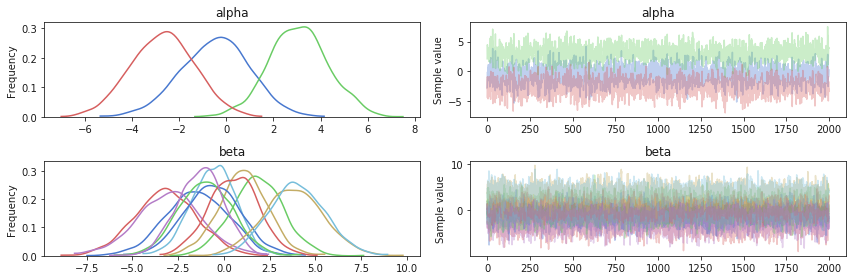

In [27]:
pm.traceplot(trace_s)


In [28]:
pm.df_summary(trace_s)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,-0.49,1.47,0.03,-3.39,2.37
alpha__1,3.08,1.27,0.03,0.66,5.67
alpha__2,-2.71,1.35,0.03,-5.27,-0.04
beta__0_0,-1.48,1.68,0.03,-4.77,1.65
beta__0_1,1.05,1.33,0.03,-1.86,3.43
beta__0_2,0.54,1.34,0.03,-2.38,2.88
beta__1_0,1.81,1.40,0.03,-0.90,4.61
beta__1_1,-0.59,1.21,0.03,-3.07,1.63
beta__1_2,-1.28,1.25,0.03,-3.70,1.01
beta__2_0,-3.18,1.69,0.03,-6.71,-0.08


In [29]:
#pm.autocorrplot(trace_s, varnames=['alpha']);

In [30]:
probs = trace_s['alpha'].mean(axis=0) + np.dot(x_s, trace_s['beta'].mean(axis=0))
y_pred = []
for point in probs:
    y_pred.append(np.exp(point)/np.sum(np.exp(point), axis=0))
np.sum(y_s == np.argmax(y_pred, axis=1))/len(y_s)

0.9733333333333334

In [31]:
with pm.Model() as model_sf:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=2)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,2))
    
    alpha_f = tt.concatenate([[0] , alpha])
    beta_f = tt.concatenate([np.zeros((4,1)) , beta], axis=1)

    mu = alpha_f + pm.math.dot(x_s, beta_f)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_sf = pm.sample(2000, step, start)

logp = -42.148, ||grad|| = 0.00098897: 100%|██████████| 37/37 [00:00<00:00, 2141.63it/s]  
100%|██████████| 2500/2500 [00:11<00:00, 217.93it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2d5fa89b0>,
      dtype=object)

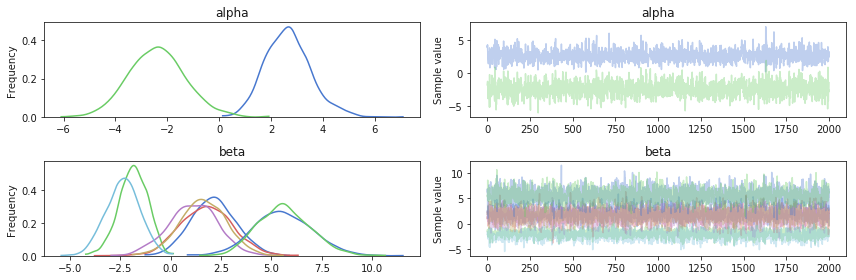

In [32]:
pm.traceplot(trace_sf)


In [33]:
pm.df_summary(trace_sf)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.67,0.88,0.02,0.99,4.46
alpha__1,-2.39,1.10,0.03,-4.56,-0.24
beta__0_0,2.12,1.11,0.03,-0.02,4.29
beta__0_1,1.62,1.13,0.03,-0.58,3.86
beta__1_0,-1.85,0.71,0.02,-3.26,-0.54
beta__1_1,-2.36,0.83,0.02,-4.04,-0.80
beta__2_0,1.79,1.29,0.04,-0.62,4.28
beta__2_1,5.57,1.46,0.04,2.79,8.48
beta__3_0,1.12,1.22,0.04,-1.54,3.22
beta__3_1,5.64,1.31,0.04,3.18,8.12


## Linear Discriminate Analysis (LDA)

In [34]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [35]:
with pm.Model() as model_lda:

    mus = pm.Normal('mus', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)
    
    setosa = pm.Normal('setosa', mu=mus[0], sd=sigma, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=mus[1], sd=sigma, observed=x_0[50:])
    
    bd = pm.Deterministic('bd', (mus[0]+mus[1])/2)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_lda = pm.sample(5000, step, start)

logp = -68.046, ||grad|| = 0.092215: 100%|██████████| 24/24 [00:00<00:00, 3106.51it/s]  
100%|██████████| 5500/5500 [00:02<00:00, 1850.90it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2baf3c208>,
      dtype=object)

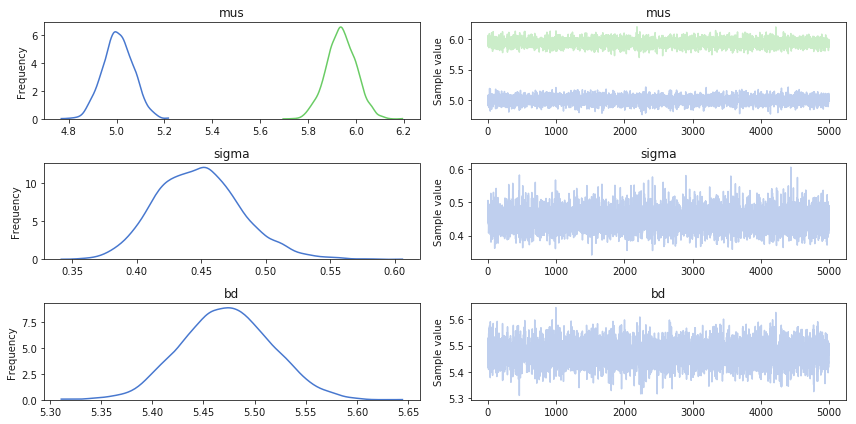

In [36]:
pm.traceplot(trace_lda)


In [37]:
pm.df_summary(trace_lda)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mus__0,5.01,0.06,7.78e-04,4.88,5.12
mus__1,5.94,0.06,8.01e-04,5.82,6.07
sigma,0.45,0.03,3.97e-04,0.38,0.51
bd,5.47,0.04,5.69e-04,5.39,5.56


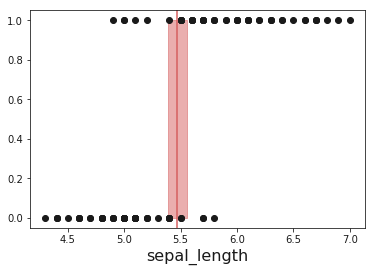

In [38]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')

plt.xlabel(x_n, fontsize=16)


In [39]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running Fedora 28 and using:
Python 3.6.3
IPython 6.1.0
PyMC3 3.2
NumPy 1.14.2
SciPy 1.0.0
Matplotlib 2.1.2
Seaborn 0.8.0
Pandas 0.22.0
